# Lighting Variation Impact on Urban Garbage Detection - GIGO Dataset Analysis

This notebook analyzes the GIGO dataset to investigate how lighting conditions affect garbage recognition performance in street-level imagery.

## Research Questions
**RQ:** How do lighting conditions affect class-specific garbage recognition performance in street-level imagery, and to what extent can explicitly modeling lighting information improve robustness under challenging conditions?

## Hypotheses
- **H1:** Poor lighting conditions lead to lower recognition performance for visually small or fine-grained garbage categories (e.g., litter) compared to larger object categories
- **H2:** Categories involving large objects (e.g., bulky waste) are less sensitive to variations in lighting conditions  
- **H3:** A CNN with lighting embeddings improves classification performance under challenging lighting conditions compared to image-only baseline

## Dataset Overview
The GIGO dataset contains:
- **25,000 street-view images** from Amsterdam
- **Metadata:** timestamps, GPS coordinates, privacy blur information
- **Annotations:** Multi-label classification for garbage categories
- **Categories:** garbage, bulky waste, garbage bag, cardboard, litter

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, time
import warnings
import cv2
import os
from PIL import Image
import ast
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, average_precision_score, recall_score

warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")


In [123]:
# GIGO 
data_path = "/Users/daniel/Documents/Applied/GIGO/"

annotations = pd.read_csv(data_path + "annotations.csv")
metadata = pd.read_csv(data_path + "metadata.csv")

print("Dataset loaded successfully!")
print(f"Annotations shape: {annotations.shape}")
print(f"Metadata shape: {metadata.shape}")

print(annotations.head())
print(metadata.head())

Dataset loaded successfully!
Annotations shape: (24999, 9)
Metadata shape: (25000, 7)
  new_filename  train  test  garbage  bulkywaste  garbagebag  cardboard  \
0    10905.jpg      1     0        1           1           1          1   
1     1544.jpg      1     0        1           1           1          1   
2     5959.jpg      1     0        0           0           0          0   
3     4695.jpg      1     0        1           1           1          1   
4    15980.jpg      1     0        0           0           0          0   

   litter                                             labels  
0       1  ['garbage', 'bulkywaste', 'garbagebag', 'cardb...  
1       1  ['garbage', 'bulkywaste', 'garbagebag', 'cardb...  
2       0                                                 []  
3       1  ['garbage', 'bulkywaste', 'garbagebag', 'cardb...  
4       0                                                 []  
    filename privacy_blurs      date   time        lat       lng  \
0   8726.jpg     

## Step 1: Load Metadata and Images

Loading metadata.csv and preparing to process images from blurred_images_all/ directory.

In [126]:
#  metadata.csv
metadata = pd.read_csv(data_path + "metadata.csv")
print(f"Loaded metadata for {len(metadata)} images")

images_dir = data_path + "blurred_images_all/"
print(f"Image directory: {images_dir}")
print(f"Number of image files: {len(os.listdir(images_dir))}")

Loaded metadata for 25000 images
Image directory: /Users/daniel/Documents/Applied/GIGO/blurred_images_all/
Number of image files: 25000


## Step 2: Compute ROI-Based Mean Brightness

Computing mean brightness from top 85% ROI while excluding privacy blur regions.

In [57]:
def compute_brightness_with_mask(image_path, privacy_blurs_str):
    """
    Compute mean brightness from central ROI (excluding 15% from all sides), excluding privacy blur regions.
    Returns: (mean_brightness_roi, blur_coverage_roi)
    """
    img = cv2.imread(image_path)
    if img is None:
        return None, None
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    height, width = gray.shape
    
    # Crop for roi to get most accurate brightness mean
    top_margin = int(height * 0.15)
    bottom_margin = int(height * 0.15)
    left_margin = int(width * 0.15)
    right_margin = int(width * 0.15)
    
    roi = gray[top_margin:height-bottom_margin, left_margin:width-right_margin]
    roi_height, roi_width = roi.shape
    
    # masks
    mask = np.ones((roi_height, roi_width), dtype=np.uint8)
    blur_area = 0
    
    # privacy blurs
    if privacy_blurs_str != '[]' and privacy_blurs_str != '':
        try:
            blur_lines = ast.literal_eval(privacy_blurs_str)
            if blur_lines:
                for blur_line in blur_lines:
                    parts = blur_line.strip().split()
                    if len(parts) == 5:
                        _, x_center, y_center, box_width, box_height = map(float, parts)
                        
                        x_center *= width
                        y_center *= height
                        box_width *= width
                        box_height *= height
                        
                        x1_full = max(0, int(x_center - box_width/2))
                        y1_full = max(0, int(y_center - box_height/2))
                        x2_full = min(width, int(x_center + box_width/2))
                        y2_full = min(height, int(y_center + box_height/2))
                        
                        x1_roi = max(0, x1_full - left_margin)
                        y1_roi = max(0, y1_full - top_margin)
                        x2_roi = min(roi_width, x2_full - left_margin)
                        y2_roi = min(roi_height, y2_full - top_margin)
                        
                        if x1_roi < roi_width and y1_roi < roi_height and x2_roi > 0 and y2_roi > 0:
                            x1_roi = max(0, x1_roi)
                            y1_roi = max(0, y1_roi)
                            x2_roi = min(roi_width, x2_roi)
                            y2_roi = min(roi_height, y2_roi)
                            mask[y1_roi:y2_roi, x1_roi:x2_roi] = 0
                            blur_area += (x2_roi-x1_roi) * (y2_roi-y1_roi)
        except:
            pass  
    
    roi_area = roi_height * roi_width
    blur_coverage_roi = blur_area / roi_area if roi_area > 0 else 0
    
    # mean
    masked_pixels = roi[mask == 1]
    mean_brightness_roi = np.mean(masked_pixels) if len(masked_pixels) > 0 else np.mean(roi)
    
    return mean_brightness_roi, blur_coverage_roi

print("Brightness computation function defined")

Brightness computation function defined


In [58]:
#check if it exists first so we dont overlap
lighting_file = data_path + "metadata_with_lighting.csv"


brightness_values = []
blur_coverages = []

total_images = len(metadata)

for idx in range(total_images):
    row = metadata.iloc[idx]
    image_path = os.path.join(images_dir, row['filename'])
    
    if os.path.exists(image_path):
        brightness, blur_coverage = compute_brightness_with_mask(
            image_path, str(row['privacy_blurs'])
        )
        brightness_values.append(brightness)
        blur_coverages.append(blur_coverage)
    else:
        brightness_values.append(None)
        blur_coverages.append(None)

metadata_with_lighting = metadata.copy()
metadata_with_lighting['mean_brightness_roi'] = brightness_values
metadata_with_lighting['blur_coverage_roi'] = blur_coverages

print(f"Total images processed: {len(metadata_with_lighting)}")
print(f"Images with valid brightness: {metadata_with_lighting['mean_brightness_roi'].notna().sum()}")
print(f"Images with failed processing: {metadata_with_lighting['mean_brightness_roi'].isna().sum()}")

Processing images for brightness computation with new central ROI method...
Processing complete
Total images processed: 25000
Images with valid brightness: 25000
Images with failed processing: 0
Processing complete
Total images processed: 25000
Images with valid brightness: 25000
Images with failed processing: 0


## Step 3: Bin Lighting Conditions

Creating quantile-based lighting categories using mean brightness from ROI.

In [59]:
# Compute quantile-based lighting bins 
all_brightness = metadata_with_lighting['mean_brightness_roi'].dropna()

q33 = all_brightness.quantile(0.33)
q67 = all_brightness.quantile(0.67)

print(f"Mean brightness ROI quantiles:")
print(f"33rd percentile: {q33:.2f}")
print(f"67th percentile: {q67:.2f}")

# lighting level categories 
def categorize_lighting(brightness):
    if pd.isna(brightness):
        return None
    elif brightness <= q33:
        return 'low_light'
    elif brightness <= q67:
        return 'medium_light'
    else:
        return 'high_light'

metadata_with_lighting['lighting_level'] = metadata_with_lighting['mean_brightness_roi'].apply(categorize_lighting)

metadata_with_lighting['lighting_level'] = pd.Categorical(
    metadata_with_lighting['lighting_level'], 
    categories=['low_light', 'medium_light', 'high_light'],
    ordered=True
)

# lighting distribution
lighting_counts = metadata_with_lighting['lighting_level'].value_counts()
print(f"\nLighting level distribution:")
print(lighting_counts)
print(f"Images with failed processing: {metadata_with_lighting['lighting_level'].isna().sum()}")

Mean brightness ROI quantiles:
33rd percentile: 107.11
67th percentile: 126.32

Lighting level distribution:
lighting_level
medium_light    8500
low_light       8250
high_light      8250
Name: count, dtype: int64
Images with failed processing: 0


## Step 4: Save Metadata with Lighting

Saving the enriched metadata with brightness and lighting information.

In [60]:
output_path = data_path + "metadata_with_lighting.csv"
metadata_with_lighting.to_csv(output_path, index=False)

print(f"Metadata with lighting saved to: {output_path}")
print(f"Metadata shape: {metadata_with_lighting.shape}")
print(f"New columns added: {set(metadata_with_lighting.columns) - set(metadata.columns)}")

Metadata with lighting saved to: /Users/daniel/Documents/Applied/GIGO/metadata_with_lighting.csv
Metadata shape: (25000, 10)
New columns added: {'mean_brightness_roi', 'blur_coverage_roi', 'lighting_level'}


## Step 5: Basic Exploratory Data Analysis (EDA)

Creating minimal EDA outputs for lighting analysis.

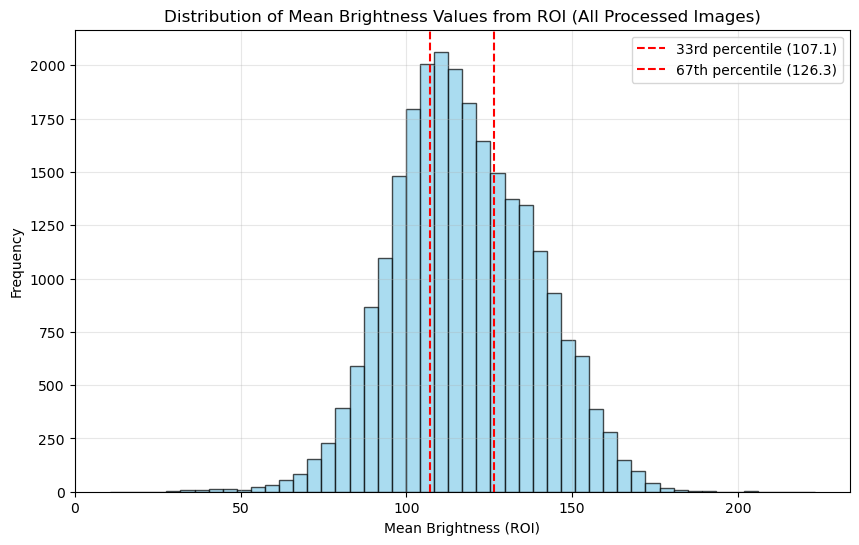

In [61]:
# Histogram of mean_brightness_roi
processed_data = metadata_with_lighting[metadata_with_lighting['mean_brightness_roi'].notna()]

plt.figure(figsize=(10, 6))
plt.hist(processed_data['mean_brightness_roi'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(q33, color='red', linestyle='--', label=f'33rd percentile ({q33:.1f})')
plt.axvline(q67, color='red', linestyle='--', label=f'67th percentile ({q67:.1f})')
plt.xlabel('Mean Brightness (ROI)')
plt.ylabel('Frequency')
plt.title('Distribution of Mean Brightness Values from ROI (All Processed Images)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [71]:
# Count of images per lighting_level
lighting_counts = metadata_with_lighting['lighting_level'].value_counts()
print("Count of images per lighting level:")
print(lighting_counts)



Count of images per lighting level:
lighting_level
medium_light    8500
low_light       8250
high_light      8250
Name: count, dtype: int64


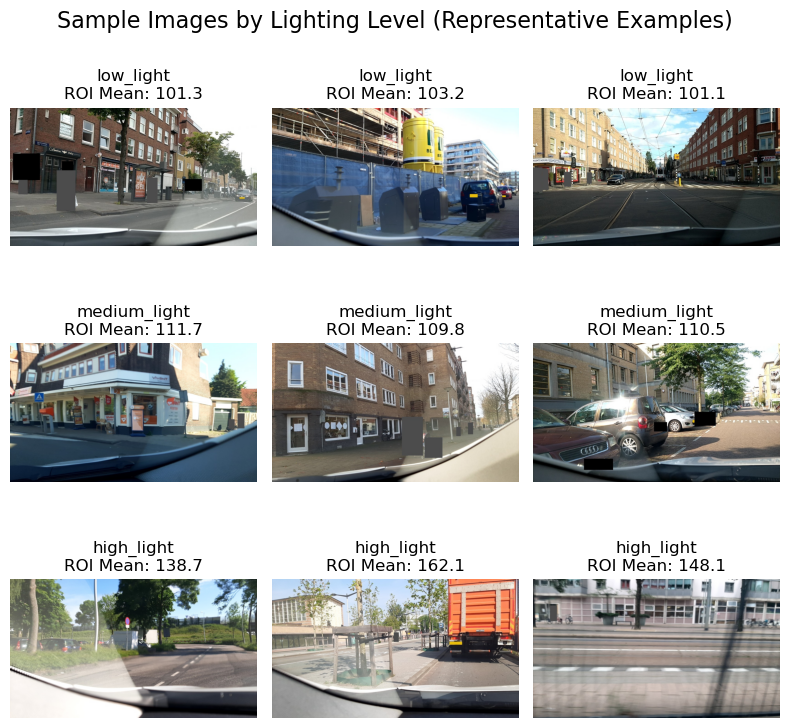

In [ ]:
# Display 3 random example images per lighting level (processed images only, excluding extreme outliers)
np.random.seed(42)  

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
fig.suptitle('Sample Images by Lighting Level (Representative Examples)', fontsize=16)

lighting_levels = ['low_light', 'medium_light', 'high_light']

for i, level in enumerate(lighting_levels):
    level_images = metadata_with_lighting[
        (metadata_with_lighting['lighting_level'] == level) & 
        (metadata_with_lighting['mean_brightness_roi'].notna())
    ]
    
    # Filter out extreme outliers (bottom 5% and top 5% within each category)
    brightness_col = level_images['mean_brightness_roi']
    lower_bound = brightness_col.quantile(0.05)
    upper_bound = brightness_col.quantile(0.95)
    
    filtered_images = level_images[
        (brightness_col >= lower_bound) & 
        (brightness_col <= upper_bound)
    ]
    
    # Sample 3 random images from filtered set
    sampled = filtered_images.sample(n=3, random_state=97) #remember 7, 92, also 88, 11
    
    for j, (idx, row) in enumerate(sampled.iterrows()):
        image_path = os.path.join(images_dir, row['filename'])
        
        img = cv2.imread(image_path)
        if img is not None:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i, j].imshow(img_rgb)
            axes[i, j].set_title(f'{level}\nROI Mean: {row["mean_brightness_roi"]:.1f}')
            axes[i, j].axis('off')
        else:
            axes[i, j].text(0.5, 0.5, 'Image not found', ha='center', va='center')
            axes[i, j].axis('off')

plt.tight_layout()
plt.show()

# Garbage Classification Model

Now we will use PyTorch for training a ResNet50 model on the GIGO dataset to analize whether or not different lighting condition impact performance.

In [64]:
# Load, merge minimal metadata, filter brightness outliers, split

annotations = pd.read_csv(data_path + "annotations.csv")
df_meta = pd.read_csv(data_path + "metadata_with_lighting.csv")

df_meta = df_meta[['filename', 'lighting_level', 'mean_brightness_roi']]
df_meta = df_meta.rename(columns={"filename": "new_filename"})

split_cols = [col for col in annotations.columns if col.lower() in 
              ['train', 'test', 'val', 'is_train', 'is_test', 'split', 'set', 'subset']]
if split_cols:
    annotations = annotations.drop(columns=split_cols)

df = annotations.merge(df_meta, on='new_filename', how='inner')

label_cols = ['garbage', 'bulkywaste', 'garbagebag', 'cardboard', 'litter']
required_cols = ['new_filename', 'lighting_level', 'mean_brightness_roi'] + label_cols
df = df.dropna(subset=required_cols)

for col in label_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.dropna(subset=label_cols)

# Remove outliers based on mean_brightness_roi within 
def remove_outliers_iqr(group):
    
    Q1 = group['mean_brightness_roi'].quantile(0.25)
    Q3 = group['mean_brightness_roi'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group[(group['mean_brightness_roi'] >= lower_bound) & 
                 (group['mean_brightness_roi'] <= upper_bound)]

df = df.groupby('lighting_level').apply(remove_outliers_iqr).reset_index(drop=True)

# 75% train, 5% val, 20% test
train_and_val, test = train_test_split(df, test_size=0.20, stratify=df['lighting_level'], random_state=42)
train, val = train_test_split(train_and_val, test_size=0.0625, stratify=train_and_val['lighting_level'], random_state=42)

split_cols = ['new_filename', 'lighting_level'] + label_cols
train[split_cols].to_csv(data_path + "train_split.csv", index=False)
val[split_cols].to_csv(data_path + "val_split.csv", index=False)
test[split_cols].to_csv(data_path + "test_split.csv", index=False)

print(f"Train: {len(train)}, Val: {len(val)}, Test: {len(test)}")
print("Split distribution:")
for split_name, split_df in [("Train", train), ("Val", val), ("Test", test)]:
    print(f"{split_name}: {split_df['lighting_level'].value_counts().to_dict()}")

Train: 18498, Val: 1234, Test: 4933
Split distribution:
Train: {'medium_light': 6374, 'high_light': 6126, 'low_light': 5998}
Val: {'medium_light': 425, 'high_light': 409, 'low_light': 400}
Test: {'medium_light': 1700, 'high_light': 1634, 'low_light': 1599}


In [65]:
# data for training

class GIGODataset(Dataset):
    def __init__(self, dataframe, image_root, transform=None):
        valid_files = []
        for _, row in dataframe.iterrows():
            if os.path.exists(os.path.join(image_root, row['new_filename'])):
                valid_files.append(row)
        
        self.df = pd.DataFrame(valid_files).reset_index(drop=True)
        self.image_root = image_root
        self.transform = transform
        self.label_cols = ['garbage', 'bulkywaste', 'garbagebag', 'cardboard', 'litter']
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # images
        img_path = os.path.join(self.image_root, row['new_filename'])
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        label_values = []
        for col in self.label_cols:
            val = row[col]
            if isinstance(val, str):
                val = float(val)
            label_values.append(val)
        labels = torch.tensor(label_values, dtype=torch.float32)
        
        return image, labels, row['lighting_level']

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# split
train_df = pd.read_csv(data_path + "train_split.csv")
val_df = pd.read_csv(data_path + "val_split.csv")
test_df = pd.read_csv(data_path + "test_split.csv")

# Create datasets
train_dataset = GIGODataset(train_df, images_dir, train_transform)
val_dataset = GIGODataset(val_df, images_dir, test_transform)
test_dataset = GIGODataset(test_df, images_dir, test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

print(f"Dataset sizes - Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Dataset sizes - Train: 18498, Val: 1234, Test: 4933


In [66]:
# training ResNet50 
import torch.nn as nn
import torchvision.models as models
from sklearn.metrics import f1_score

assert torch.backends.mps.is_available()
device = torch.device("mps")

model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 5)
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

# loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, labels, _ in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Val
    model.eval()
    val_preds, val_labels = [], []
    with torch.no_grad():
        for images, labels, _ in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy()
            val_preds.extend(preds)
            val_labels.extend(labels.cpu().numpy())
    
    val_f1 = f1_score(val_labels, val_preds, average='macro')
    print(f"Epoch {epoch+1}: Train Loss: {train_loss/len(train_loader):.4f}, Val Macro-F1: {val_f1:.4f}")


model_path = data_path + "resnet50_gigo_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Training complete. Model saved to: {model_path}")

Epoch 1: Train Loss: 0.3535, Val Macro-F1: 0.5903
Epoch 2: Train Loss: 0.3256, Val Macro-F1: 0.6121
Epoch 2: Train Loss: 0.3256, Val Macro-F1: 0.6121
Epoch 3: Train Loss: 0.3186, Val Macro-F1: 0.6067
Epoch 3: Train Loss: 0.3186, Val Macro-F1: 0.6067
Epoch 4: Train Loss: 0.3113, Val Macro-F1: 0.6456
Epoch 4: Train Loss: 0.3113, Val Macro-F1: 0.6456
Epoch 5: Train Loss: 0.3043, Val Macro-F1: 0.5981
Training complete. Model saved to: /Users/daniel/Documents/Applied/GIGO/resnet50_gigo_model.pth
Epoch 5: Train Loss: 0.3043, Val Macro-F1: 0.5981
Training complete. Model saved to: /Users/daniel/Documents/Applied/GIGO/resnet50_gigo_model.pth


In [ ]:
# Test set
model.eval()
test_probs, test_preds, test_labels, test_lighting = [], [], [], []

with torch.no_grad():
    for images, labels, lighting in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.sigmoid(outputs).cpu().numpy()
        preds = (probs > 0.5).astype(int)
        test_probs.extend(probs)
        test_preds.extend(preds)
        test_labels.extend(labels.cpu().numpy())
        test_lighting.extend(lighting)

test_probs = np.array(test_probs)
test_preds = np.array(test_preds)
test_labels = np.array(test_labels)

# class names
label_names = ['garbage', 'bulkywaste', 'garbagebag', 'cardboard', 'litter']
lighting_levels = ['low_light', 'medium_light', 'high_light']

print(f"done. Test samples: {len(test_labels)}")

In [122]:
# Results from test set used on model 
print("----------Overall Results----------")

# Compute overall metrics
overall_ap = [average_precision_score(test_labels[:, i], test_probs[:, i]) for i in range(5)]
overall_f1 = f1_score(test_labels, test_preds, average=None)
overall_recall = recall_score(test_labels, test_preds, average=None)

macro_ap = np.mean(overall_ap)
macro_f1 = f1_score(test_labels, test_preds, average='macro')
macro_recall = recall_score(test_labels, test_preds, average='macro')

# Print overall results table
print(f"{'Class':<12} {'mAP@0.50':<8} {'F1':<8} {'Recall':<8}")
print("-" * 38)
for i, label in enumerate(label_names):
    print(f"{label:<12} {overall_ap[i]:.3f}    {overall_f1[i]:.3f}    {overall_recall[i]:.3f}")
print("-" * 38)
print(f"{'Macro':<12} {macro_ap:.3f}    {macro_f1:.3f}    {macro_recall:.3f}")
print()


print("----------Results based on Lighting Level----------")

# Compute results by lighting level
lighting_results = {}
for lighting in lighting_levels:
    mask = np.array(test_lighting) == lighting
    level_probs = test_probs[mask]
    level_preds = test_preds[mask]
    level_labels = test_labels[mask]
    
    level_ap = [average_precision_score(level_labels[:, i], level_probs[:, i]) for i in range(5)]
    level_f1 = f1_score(level_labels, level_preds, average=None)
    level_recall = recall_score(level_labels, level_preds, average=None)
    
    lighting_results[lighting] = {
        'ap': level_ap,
        'f1': level_f1,
        'recall': level_recall,
        'macro_ap': np.mean(level_ap),
        'macro_f1': f1_score(level_labels, level_preds, average='macro'),
        'macro_recall': recall_score(level_labels, level_preds, average='macro'),
        'n_samples': len(level_labels)
    }

# Summary table by lighting level
print(f"{'Lighting':<12} {'mAP@0.50':<9} {'Macro-F1':<9} {'Macro-Rec':<10} {'n':<6}")
print("-" * 48)
for lighting in lighting_levels:
    results = lighting_results[lighting]
    print(f"{lighting:<12} {results['macro_ap']:.3f}     {results['macro_f1']:.3f}     {results['macro_recall']:.3f}      {results['n_samples']}")
print()

# Per-class results by lighting level
for lighting in lighting_levels:
    print(f"{lighting.upper()} LIGHT:")
    print(f"{'Class':<12} {'mAP@0.50':<8} {'F1':<8} {'Recall':<8}")
    print("-" * 38)
    results = lighting_results[lighting]
    for i, label in enumerate(label_names):
        print(f"{label:<12} {results['ap'][i]:.3f}    {results['f1'][i]:.3f}    {results['recall'][i]:.3f}")
    print()

----------Overall Results----------
Class        mAP@0.50 F1       Recall  
--------------------------------------
garbage      0.897    0.796    0.715
bulkywaste   0.743    0.648    0.578
garbagebag   0.568    0.359    0.225
cardboard    0.753    0.618    0.513
litter       0.591    0.503    0.397
--------------------------------------
Macro        0.710    0.585    0.486

----------Results based on Lighting Level----------
Lighting     mAP@0.50  Macro-F1  Macro-Rec  n     
------------------------------------------------
low_light    0.729     0.600     0.506      1599
medium_light 0.714     0.588     0.493      1700
low_light    0.729     0.600     0.506      1599
high_light   0.652     0.532     0.422      1634
low_light    0.729     0.600     0.506      1599

LOW_LIGHT LIGHT:
Class        mAP@0.50 F1       Recall  
--------------------------------------
garbage      0.930    0.825    0.763
bulkywaste   0.749    0.643    0.574
garbagebag   0.602    0.409    0.267
cardboard    0.756

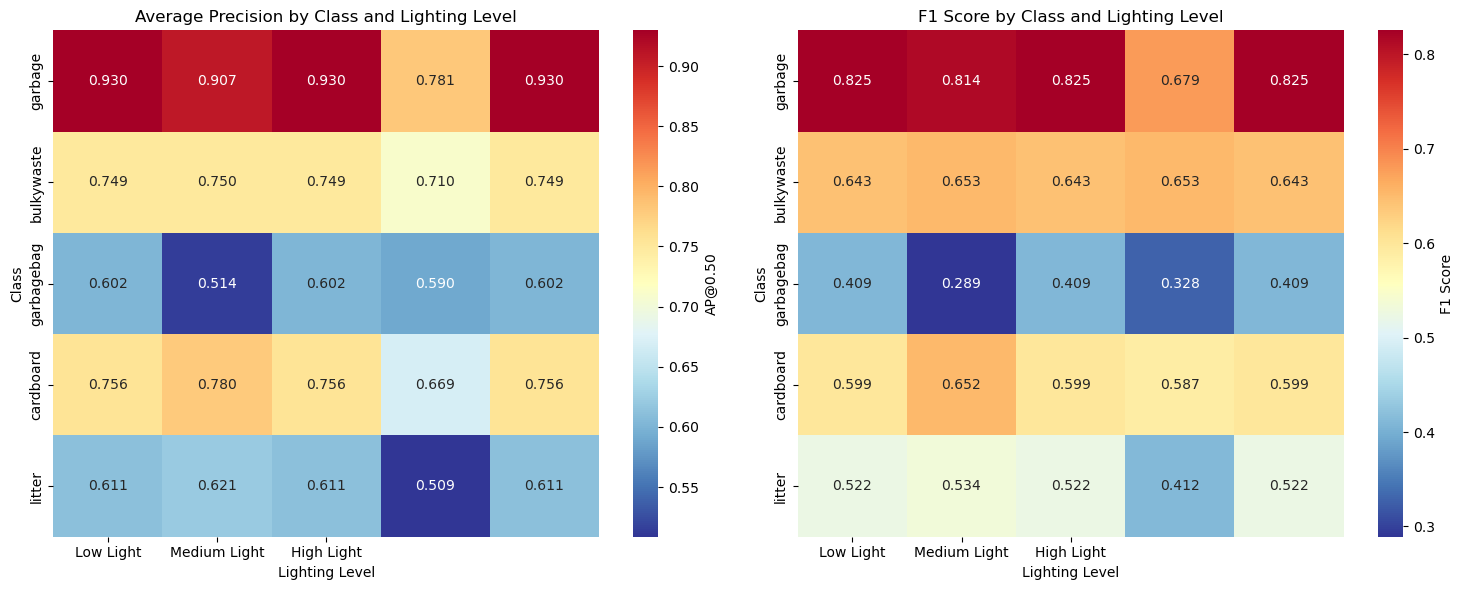

Confusion Matrix - LOW_LIGHT


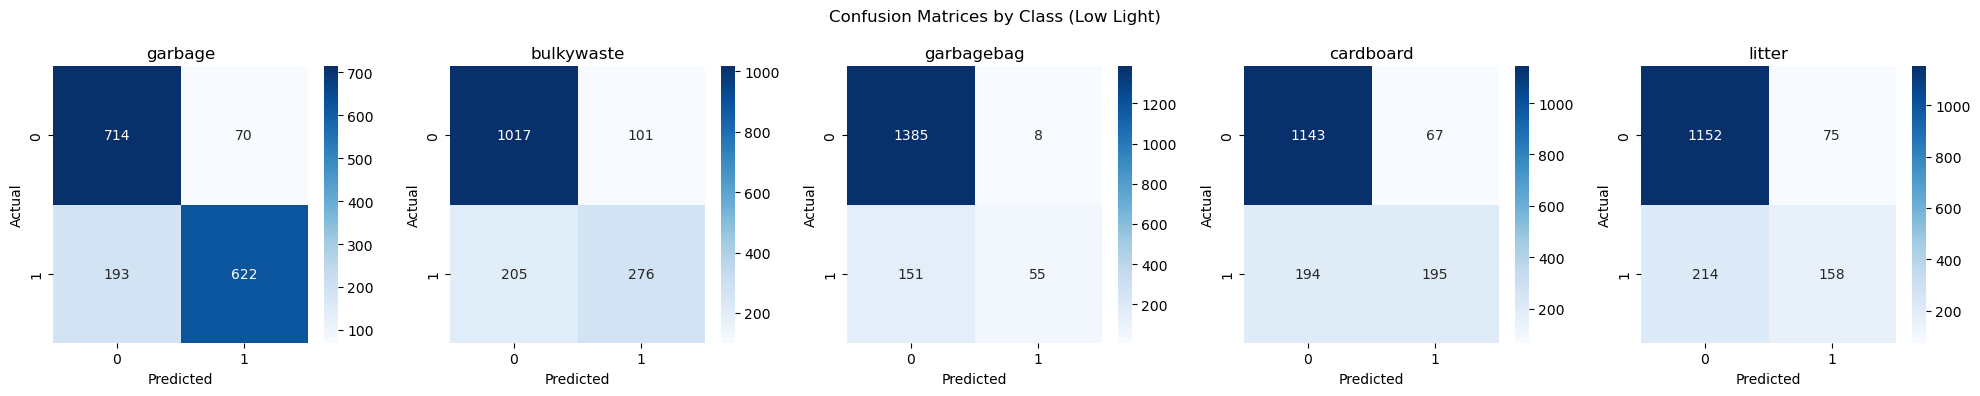

Confusion Matrix - MEDIUM_LIGHT


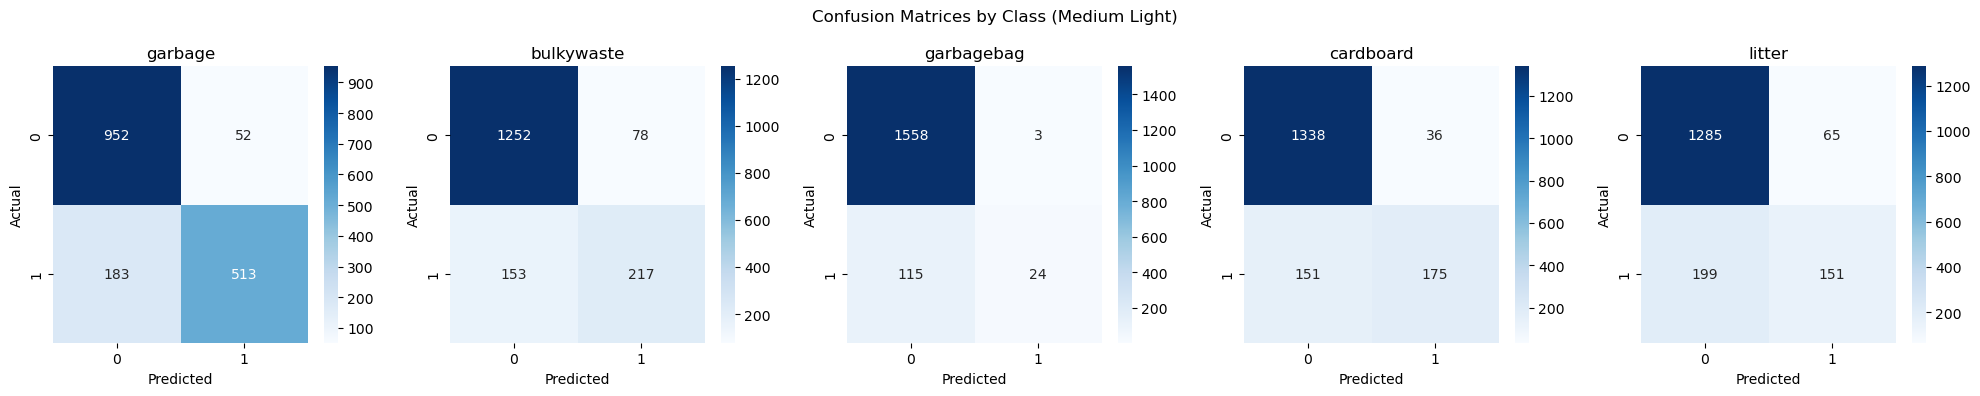

Confusion Matrix - LOW_LIGHT


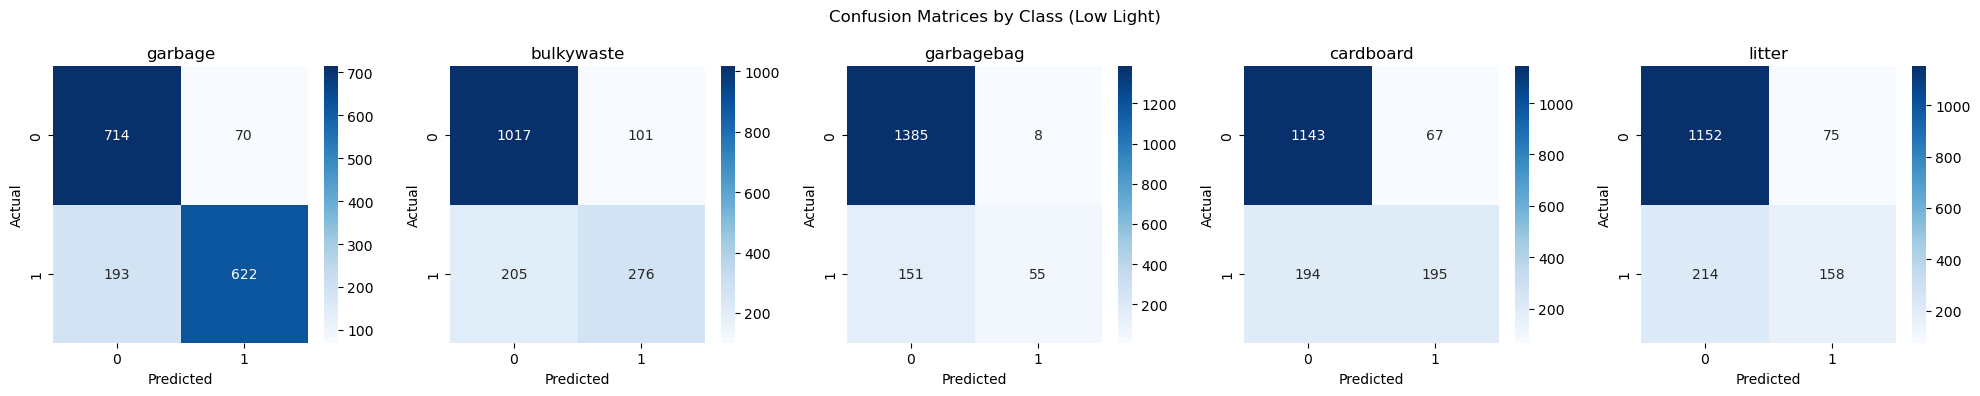

Confusion Matrix - HIGH_LIGHT


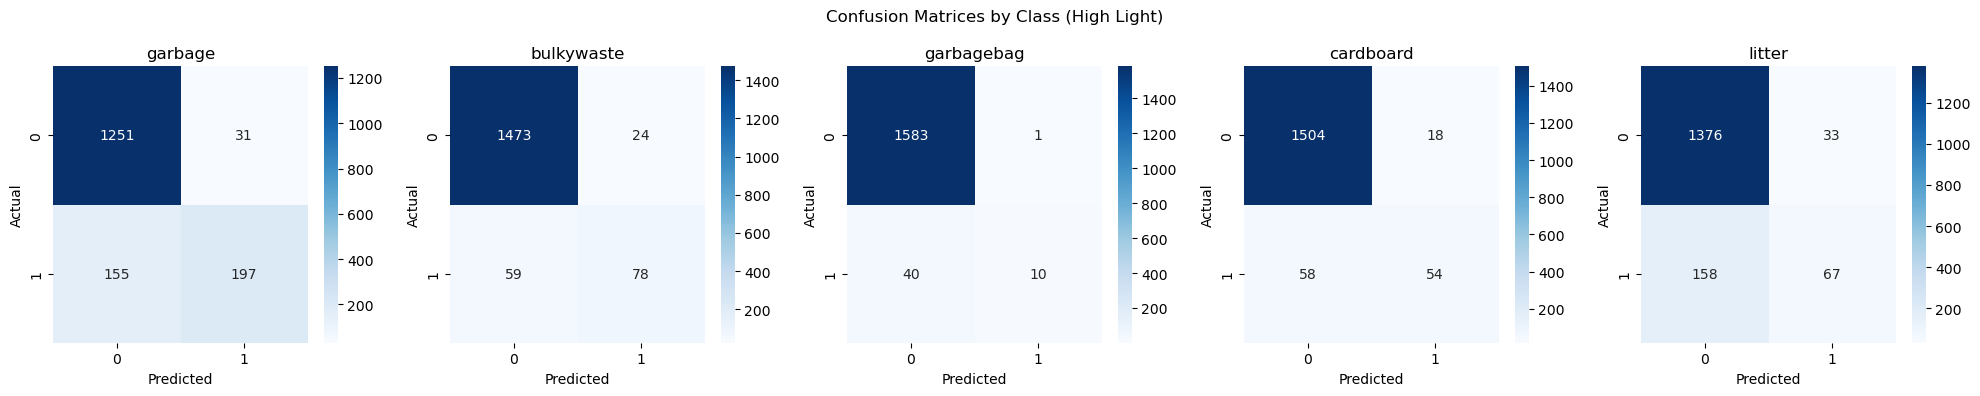

Confusion Matrix - LOW_LIGHT


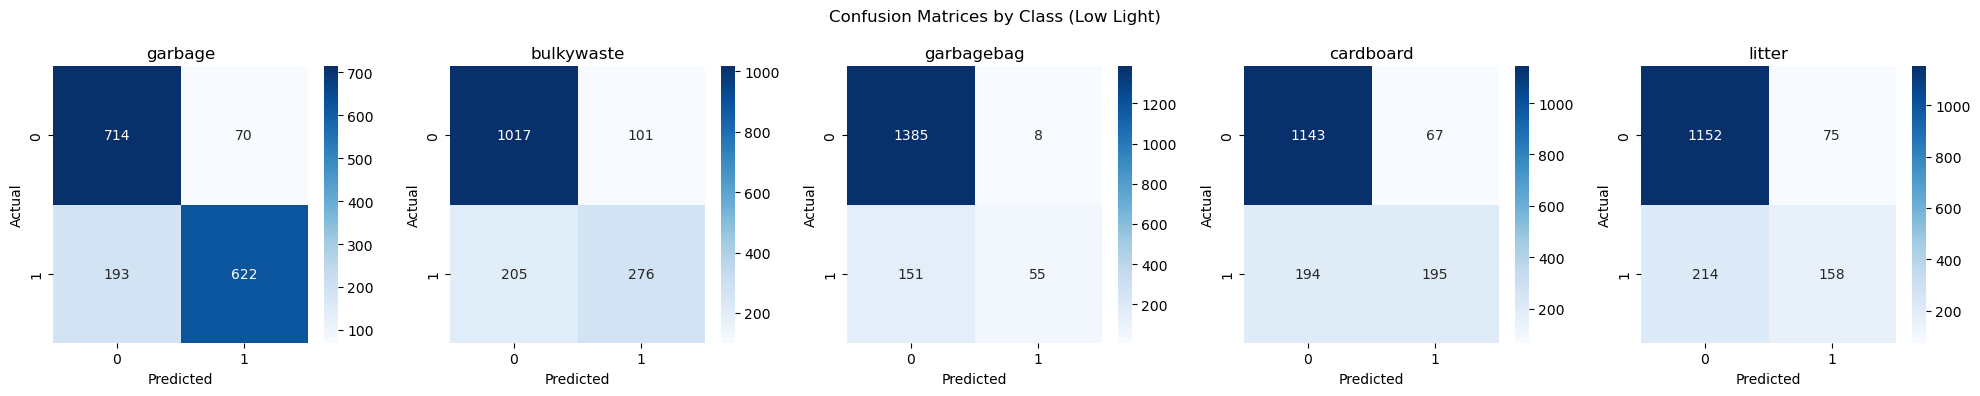

In [120]:
# heatmaps and confusion matrices

# Performance Heatmaps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# AP heatmap
ap_matrix = np.array([[lighting_results[light]['ap'][i] for light in lighting_levels] for i in range(5)])
sns.heatmap(ap_matrix, annot=True, fmt='.3f', cmap='RdYlBu_r',
           xticklabels=['Low Light', 'Medium Light', 'High Light'],
           yticklabels=label_names, ax=ax1, cbar_kws={'label': 'AP@0.50'})
ax1.set_title('Average Precision by Class and Lighting Level')
ax1.set_xlabel('Lighting Level')
ax1.set_ylabel('Class')

# F1 heatmap  
f1_matrix = np.array([[lighting_results[light]['f1'][i] for light in lighting_levels] for i in range(5)])
sns.heatmap(f1_matrix, annot=True, fmt='.3f', cmap='RdYlBu_r',
           xticklabels=['Low Light', 'Medium Light', 'High Light'], 
           yticklabels=label_names, ax=ax2, cbar_kws={'label': 'F1 Score'})
ax2.set_title('F1 Score by Class and Lighting Level')
ax2.set_xlabel('Lighting Level')
ax2.set_ylabel('Class')

plt.tight_layout()
plt.show()



# Confusion Matrices - By Lighting Level
for lighting in lighting_levels:
    print(f"Confusion Matrix - {lighting.upper()}")
    mask = np.array(test_lighting) == lighting
    level_preds = test_preds[mask]
    level_labels = test_labels[mask]
    
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    for i, class_name in enumerate(label_names):
        cm = confusion_matrix(level_labels[:, i], level_preds[:, i])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_title(f'{class_name}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')
    plt.suptitle(f'Confusion Matrices by Class ({lighting.replace("_", " ").title()})')
    plt.tight_layout()
    plt.show()



In [72]:
# Significance Test to see if high light is statistically worse than the others using (Bootstrap)
# Bootstrap resampling function
def bootstrap_f1_difference(labels1, preds1, labels2, preds2, n_bootstrap=1000):
    np.random.seed(42)  
    
    n1, n2 = len(labels1), len(labels2)
    differences = []
    
    for _ in range(n_bootstrap):
        idx1 = np.random.choice(n1, n1, replace=True)
        idx2 = np.random.choice(n2, n2, replace=True)
        
        f1_1 = f1_score(labels1[idx1], preds1[idx1], average='macro')
        f1_2 = f1_score(labels2[idx2], preds2[idx2], average='macro')
        
        differences.append(f1_1 - f1_2)
    
    return np.array(differences)

high_mask = np.array(test_lighting) == 'high_light'
low_mask = np.array(test_lighting) == 'low_light'
medium_mask = np.array(test_lighting) == 'medium_light'

high_labels = test_labels[high_mask]
high_preds = test_preds[high_mask]
low_labels = test_labels[low_mask]
low_preds = test_preds[low_mask]
medium_labels = test_labels[medium_mask]
medium_preds = test_preds[medium_mask]


# Low vs High
low_high_diff = bootstrap_f1_difference(low_labels, low_preds, high_labels, high_preds)
low_high_mean = np.mean(low_high_diff)
low_high_ci = np.percentile(low_high_diff, [2.5, 97.5])
low_high_p = np.mean(low_high_diff <= 0)

# Medium vs High  
medium_high_diff = bootstrap_f1_difference(medium_labels, medium_preds, high_labels, high_preds)
medium_high_mean = np.mean(medium_high_diff)
medium_high_ci = np.percentile(medium_high_diff, [2.5, 97.5])
medium_high_p = np.mean(medium_high_diff <= 0)

# Results
print(f"\nLow vs High: Change in F1 = {low_high_mean:.3f}, p = {low_high_p:.3f}, {'significant' if low_high_p < 0.05 else 'not significant'}")
print(f"             95% CI: [{low_high_ci[0]:.3f}, {low_high_ci[1]:.3f}]")

print(f"\nMedium vs High: Change in F1 = {medium_high_mean:.3f}, p = {medium_high_p:.3f}, {'significant' if medium_high_p < 0.05 else 'not significant'}")
print(f"               95% CI: [{medium_high_ci[0]:.3f}, {medium_high_ci[1]:.3f}]")




Low vs High: Change in F1 = 0.068, p = 0.006, significant
             95% CI: [0.015, 0.119]

Medium vs High: Change in F1 = 0.057, p = 0.024, significant
               95% CI: [0.001, 0.114]


# Lighting Embedding Model Variant

Now we implement a lighting embedding model to test hypothesis H3: whether explicitly modeling lighting information improves classification performance under challenging conditions.

In [74]:
# embedding split files and dataset

lighting_to_id = {'low_light': 0, 'medium_light': 1, 'high_light': 2}

for split in ['train', 'val', 'test']:
    # Read original split
    df = pd.read_csv(data_path + f"{split}_split.csv")
    
    # Add lighting_id column
    df['lighting_id'] = df['lighting_level'].map(lighting_to_id)
    
    # Save new embedding split file
    df.to_csv(data_path + f"{split}_split_embed.csv", index=False)
    print(f"Created {split}_split_embed.csv with lighting_id column")

# Define embedding dataset class
class GIGOEmbedDataset(Dataset):
    def __init__(self, dataframe, image_root, transform=None):
        # Drop rows where image file doesn't exist
        valid_files = []
        for _, row in dataframe.iterrows():
            if os.path.exists(os.path.join(image_root, row['new_filename'])):
                valid_files.append(row)
        
        self.df = pd.DataFrame(valid_files).reset_index(drop=True)
        self.image_root = image_root
        self.transform = transform
        self.label_cols = ['garbage', 'bulkywaste', 'garbagebag', 'cardboard', 'litter']
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Load image
        img_path = os.path.join(self.image_root, row['new_filename'])
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        # Labels as float32
        label_values = []
        for col in self.label_cols:
            val = row[col]
            if isinstance(val, str):
                val = float(val)
            label_values.append(val)
        labels = torch.tensor(label_values, dtype=torch.float32)
        
        # Lighting ID as long tensor for embedding lookup
        lighting_id = torch.tensor(row['lighting_id'], dtype=torch.long)
        
        return image, labels, lighting_id, row['lighting_level']

# Load embedding split data
train_embed_df = pd.read_csv(data_path + "train_split_embed.csv")
val_embed_df = pd.read_csv(data_path + "val_split_embed.csv")
test_embed_df = pd.read_csv(data_path + "test_split_embed.csv")

# Create embedding datasets (reuse existing transforms)
train_embed_dataset = GIGOEmbedDataset(train_embed_df, images_dir, train_transform)
val_embed_dataset = GIGOEmbedDataset(val_embed_df, images_dir, test_transform)
test_embed_dataset = GIGOEmbedDataset(test_embed_df, images_dir, test_transform)

# Create embedding dataloaders
train_embed_loader = DataLoader(train_embed_dataset, batch_size=32, shuffle=True, num_workers=0)
val_embed_loader = DataLoader(val_embed_dataset, batch_size=32, shuffle=False, num_workers=0)
test_embed_loader = DataLoader(test_embed_dataset, batch_size=32, shuffle=False, num_workers=0)

print(f"Embedding dataset sizes - Train: {len(train_embed_dataset)}, Val: {len(val_embed_dataset)}, Test: {len(test_embed_dataset)}")

Created train_split_embed.csv with lighting_id column
Created val_split_embed.csv with lighting_id column
Created test_split_embed.csv with lighting_id column
Embedding dataset sizes - Train: 18498, Val: 1234, Test: 4933


In [75]:
# train lighting embedding model
class LightingEmbedModel(nn.Module):
    def __init__(self, num_classes=5, lighting_embed_dim=16):
        super().__init__()
        
        self.backbone = models.resnet50(pretrained=True)
        self.backbone.fc = nn.Identity()
        
        self.lighting_embed = nn.Embedding(3, lighting_embed_dim)
        
        self.classifier = nn.Linear(2048 + lighting_embed_dim, num_classes)
    
    def forward(self, images, lighting_ids):
        img_features = self.backbone(images)  
        
        lighting_embeds = self.lighting_embed(lighting_ids) 
        
        combined_features = torch.cat([img_features, lighting_embeds], dim=1)  
        
        logits = self.classifier(combined_features)
        
        return logits

assert torch.backends.mps.is_available()
device = torch.device("mps")

embed_model = LightingEmbedModel()
embed_model = embed_model.to(device)

embed_criterion = nn.BCEWithLogitsLoss()
embed_optimizer = torch.optim.AdamW(embed_model.parameters(), lr=1e-4)

num_epochs = 5
print("Training...")

for epoch in range(num_epochs):
    # Train
    embed_model.train()
    train_loss = 0
    for images, labels, lighting_ids, _ in train_embed_loader:
        images, labels, lighting_ids = images.to(device), labels.to(device), lighting_ids.to(device)
        
        embed_optimizer.zero_grad()
        outputs = embed_model(images, lighting_ids)
        loss = embed_criterion(outputs, labels)
        loss.backward()
        embed_optimizer.step()
        
        train_loss += loss.item()
    
    # Val
    embed_model.eval()
    val_preds, val_labels = [], []
    with torch.no_grad():
        for images, labels, lighting_ids, _ in val_embed_loader:
            images, labels, lighting_ids = images.to(device), labels.to(device), lighting_ids.to(device)
            outputs = embed_model(images, lighting_ids)
            preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy()
            val_preds.extend(preds)
            val_labels.extend(labels.cpu().numpy())
    
    val_f1 = f1_score(val_labels, val_preds, average='macro')
    print(f"Epoch {epoch+1}: Train Loss: {train_loss/len(train_embed_loader):.4f}, Val Macro-F1: {val_f1:.4f}")

# Save embedding model weights
embed_model_path = data_path + "resnet50_gigo_embed_model.pth"
torch.save(embed_model.state_dict(), embed_model_path)
print(f"Training complete. {embed_model_path}")

Training lighting embedding model...
Epoch 1: Train Loss: 0.3559, Val Macro-F1: 0.5859
Epoch 2: Train Loss: 0.3288, Val Macro-F1: 0.5748
Epoch 3: Train Loss: 0.3157, Val Macro-F1: 0.6123
Epoch 4: Train Loss: 0.3091, Val Macro-F1: 0.6391
Epoch 5: Train Loss: 0.3082, Val Macro-F1: 0.6444
Training complete. Embedding model saved to: /Users/daniel/Documents/Applied/GIGO/resnet50_gigo_embed_model.pth


In [116]:
# Test set for embedding model
embed_model.eval()
embed_test_probs, embed_test_preds, embed_test_labels, embed_test_lighting = [], [], [], []

with torch.no_grad():
    for images, labels, lighting_ids, lighting_levels in test_embed_loader:
        images, labels, lighting_ids = images.to(device), labels.to(device), lighting_ids.to(device)
        outputs = embed_model(images, lighting_ids)
        probs = torch.sigmoid(outputs).cpu().numpy()
        preds = (probs > 0.5).astype(int)
        embed_test_probs.extend(probs)
        embed_test_preds.extend(preds)
        embed_test_labels.extend(labels.cpu().numpy())
        embed_test_lighting.extend(lighting_levels)

embed_test_probs = np.array(embed_test_probs)
embed_test_preds = np.array(embed_test_preds)
embed_test_labels = np.array(embed_test_labels)

print(f"inference complete. Test samples: {len(embed_test_labels)}")

inference complete. Test samples: 4933


In [114]:
# Results for embedding model - same as baseline version

embed_overall_ap = [average_precision_score(embed_test_labels[:, i], embed_test_probs[:, i]) for i in range(5)]
embed_overall_f1 = f1_score(embed_test_labels, embed_test_preds, average=None)
embed_overall_recall = recall_score(embed_test_labels, embed_test_preds, average=None)

embed_macro_ap = np.mean(embed_overall_ap)
embed_macro_f1 = f1_score(embed_test_labels, embed_test_preds, average='macro')
embed_macro_recall = recall_score(embed_test_labels, embed_test_preds, average='macro')

print("Overall test set results for EMBEDDING MODEL")
print(f"{'Class':<12} {'mAP@0.50':<8} {'F1':<8} {'Recall':<8}")
print("-" * 38)
for i, label in enumerate(label_names):
    print(f"{label:<12} {embed_overall_ap[i]:.3f}    {embed_overall_f1[i]:.3f}    {embed_overall_recall[i]:.3f}")
print("-" * 38)
print(f"{'Macro':<12} {embed_macro_ap:.3f}    {embed_macro_f1:.3f}    {embed_macro_recall:.3f}")
print()

print("=" * 60)
print("Lighting level results")
print("=" * 60)

embed_lighting_results = {}
for lighting in lighting_levels:
    mask = np.array(embed_test_lighting) == lighting
    level_probs = embed_test_probs[mask]
    level_preds = embed_test_preds[mask]
    level_labels = embed_test_labels[mask]
    
    level_ap = [average_precision_score(level_labels[:, i], level_probs[:, i]) for i in range(5)]
    level_f1 = f1_score(level_labels, level_preds, average=None)
    level_recall = recall_score(level_labels, level_preds, average=None)
    
    embed_lighting_results[lighting] = {
        'ap': level_ap,
        'f1': level_f1,
        'recall': level_recall,
        'macro_ap': np.mean(level_ap),
        'macro_f1': f1_score(level_labels, level_preds, average='macro'),
        'macro_recall': recall_score(level_labels, level_preds, average='macro'),
        'n_samples': len(level_labels)
    }

print(f"{'Lighting':<12} {'mAP@0.50':<9} {'Macro-F1':<9} {'Macro-Rec':<10} {'n':<6}")
print("-" * 48)
for lighting in lighting_levels:
    results = embed_lighting_results[lighting]
    print(f"{lighting:<12} {results['macro_ap']:.3f}     {results['macro_f1']:.3f}     {results['macro_recall']:.3f}      {results['n_samples']}")
print()

for lighting in lighting_levels:
    print(f"{lighting.upper()} Light :")
    print(f"{'Class':<12} {'AP@0.50':<8} {'F1':<8} {'Recall':<8}")
    print("-" * 38)
    results = embed_lighting_results[lighting]
    for i, label in enumerate(label_names):
        print(f"{label:<12} {results['ap'][i]:.3f}    {results['f1'][i]:.3f}    {results['recall'][i]:.3f}")
    print()

if 'macro_f1' in globals():
    print("baseline vs embedding model comparison")
    print(f"{'Metric':<15} {'Baseline':<10} {'Embedding':<10} {'Improvement':<12}")
    print("-" * 50)
    
    baseline_macro_f1 = globals()['macro_f1']
    baseline_macro_ap = globals()['macro_ap']
    baseline_macro_recall = globals()['macro_recall']
    
    print(f"{'mAP@0.50':<15} {baseline_macro_ap:.3f}      {embed_macro_ap:.3f}      {embed_macro_ap - baseline_macro_ap:+.3f}")
    print(f"{'F1':<15} {baseline_macro_f1:.3f}      {embed_macro_f1:.3f}      {embed_macro_f1 - baseline_macro_f1:+.3f}")
    print(f"{'Recall':<15} {baseline_macro_recall:.3f}      {embed_macro_recall:.3f}      {embed_macro_recall - baseline_macro_recall:+.3f}")

print("\nEmbedding model analysis complete!")

Overall test set results for EMBEDDING MODEL
Class        mAP@0.50 F1       Recall  
--------------------------------------
garbage      0.898    0.810    0.755
bulkywaste   0.745    0.704    0.728
garbagebag   0.591    0.448    0.306
cardboard    0.758    0.653    0.588
litter       0.590    0.531    0.455
--------------------------------------
Macro        0.716    0.629    0.566

Lighting level results
Lighting     mAP@0.50  Macro-F1  Macro-Rec  n     
------------------------------------------------
low_light    0.737     0.656     0.607      1599
medium_light 0.717     0.618     0.566      1700
high_light   0.652     0.566     0.466      1634

LOW_LIGHT Light :
Class        AP@0.50  F1       Recall  
--------------------------------------
garbage      0.929    0.845    0.820
bulkywaste   0.756    0.707    0.736
garbagebag   0.630    0.510    0.364
cardboard    0.757    0.652    0.599
litter       0.614    0.567    0.516

MEDIUM_LIGHT Light :
Class        AP@0.50  F1       Recall  